# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from gkmexplain on Nanog ChIP-seq data in H1ESCs. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

Couldn't import dot_parser, loading of dot files will not be possible.
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


TF-MoDISco is using the TensorFlow backend.


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz -O gkmexplain_positives_impscores.txt.gz
!gunzip gkmexplain_positives_impscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/c8ebc38/modisco/gkmexplain_scores/gkmexplain_dnshuff_impscores.txt.gz -O gkmexplain_dnshuff_impscores.txt.gz
!gunzip gkmexplain_dnshuff_impscores.txt.gz

--2019-02-13 14:54:30--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.196.133
Connecting to raw.githubusercontent.com|151.101.196.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.05s   

2019-02-13 14:54:31 (1.52 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2019-02-13 14:54:31--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.196.133
Connecting to raw.githubusercontent.com|151.101.196.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1000384 (977K) [application/octet-stream]
Saving to: 'gkmexplain_positives_impscores.txt.gz'

100%[=====

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x)) for x,y,z in zip(impscores,onehot_data,hyp_impscores)]))==0

#Read in scores on the dinucleotide-shuffled sequences, taking
# the sum across ACGT at each position, to get an empirical null distribution
# of per-position importance scores
nulldist_perposimp = [
    np.array( [sum([float(z) for z in y.split(",")]) for
                y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_dnshuff_impscores.txt")]

Num onehot sequences: 960


Double check by plotting

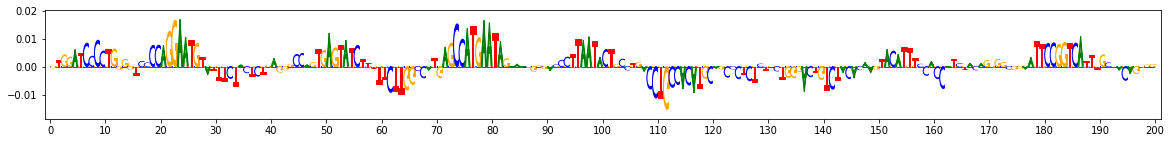

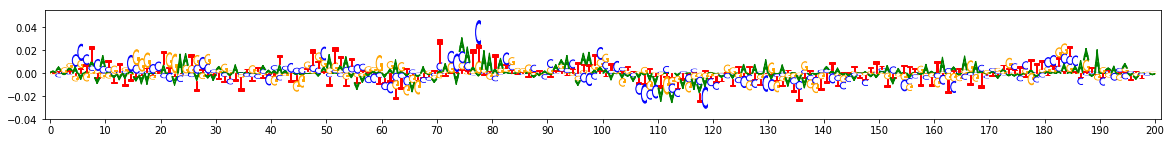

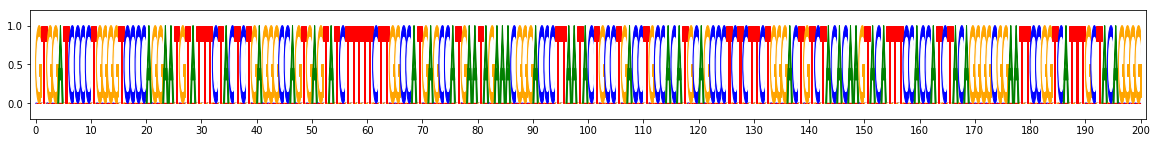

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- The code below uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
Thresholds from null dist were -0.3373419  and  0.29233143999999983
Final raw thresholds are -0.3373419  and  0.29233143999999983
Final transformed thresholds are -0.954056712962963  and  0.9289004629629629


TF-MoDISco is using the TensorFlow backend.


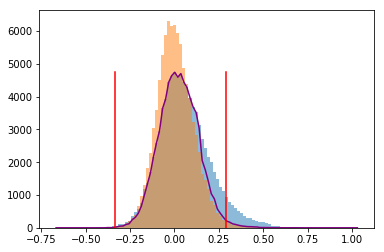

Got 807 coords
After resolving overlaps, got 807 seqlets
Across all tasks, the weakest transformed threshold used was: 0.928900362962963
807 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [771]
Idx to activities:  {0: '1'}
On metacluster 0
Metacluster size 771
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 771
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.91 s
Starting affinity matrix computations
Normalization computed in 0.03 s
Cosine similarity mat computed in 0.06 s
Normalization computed in 0.02 s
Cosine similarity mat computed in 0.06 s
Finished affinity matrix computations in 0.13 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.04 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation

[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished


Louvain completed 200 runs in 4.03665995598 seconds
Wrote graph to binary file in 0.231684207916 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.64932
After 35 runs, maximum modularity is Q = 0.652638
Louvain completed 85 runs in 2.59788799286 seconds
Preproc + Louvain took 6.99566411972 s
Got 6 clusters after round 1
Counts:
{0: 218, 1: 180, 2: 165, 3: 92, 4: 80, 5: 12}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 218 seqlets
Trimmed 5 out of 218
Skipped 22 seqlets
Aggregating for cluster 1 with 180 seqlets
Trimmed 9 out of 180
Skipped 22 seqlets
Aggregating for cluster 2 with 165 seqlets
Trimmed 26 out of 165
Skipped 22 seqlets
Aggregating for cluster 3 with 92 seqlets
Trimmed 5 out of 92
Skipped 17 seqlets
Aggregating for cluster 4 with 80 seqlets
Trimmed 0 out of 80
Skipped 17 seqlets
Aggregating for cluster 5 with 12 seqlets
Trimmed 0 out of 12
Skipped 4 seqlets
(Round 2) num seqlets: 598
(Round 2) Computing

[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.0s finished


Louvain completed 200 runs in 3.49135494232 seconds
Wrote graph to binary file in 0.200974941254 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.648068
After 6 runs, maximum modularity is Q = 0.649811
Louvain completed 56 runs in 1.58917593956 seconds
Preproc + Louvain took 5.39717006683 s
Got 6 clusters after round 2
Counts:
{0: 174, 1: 163, 2: 133, 3: 68, 4: 33, 5: 27}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 174 seqlets
Trimmed 9 out of 174
Aggregating for cluster 1 with 163 seqlets
Trimmed 33 out of 163
Aggregating for cluster 2 with 133 seqlets
Trimmed 3 out of 133
Aggregating for cluster 3 with 68 seqlets
Trimmed 16 out of 68
Aggregating for cluster 4 with 33 seqlets
Trimmed 2 out of 33
Aggregating for cluster 5 with 27 seqlets
Trimmed 2 out of 27
Skipped 1 seqlets
Got 6 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.0340249538422 seconds
Running L

In [69]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                        target_seqlet_fdr=0.2,
                        seqlets_to_patterns_factory=
                            modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                                #Adjust trim_to_window_size and initial_flank_to_add
                                # according to how big you expect
                                # the core motif to be; default value is 10
                                #trim_to_window_size=6,
                                #initial_flank_to_add=2,
                                #final_flank_to_add=5,
                                #kmer_len, num_gaps and num_mismatches are used to
                                # derive kmer embeddings for coarse-grained affinity
                                # matrix calculation. kmer_len=6, num_gaps=1
                                # and num_mismatches=0 means
                                # that kmer embeddings using 6-mers with 1 gap will be
                                # used.
                                kmer_len=6, num_gaps=1,
                                num_mismatches=0,
                                final_min_cluster_size=20,
                                min_num_to_trim_to=20,
                        ),
                   )(
                #There is only one task, so we just call this 'task0'
                task_names=["task0"],
                contrib_scores={'task0': impscores},                
                hypothetical_contribs={'task0': hyp_impscores},
                one_hot=onehot_data,
                null_per_pos_scores={'task0': nulldist_perposimp})

In [107]:
#Take the affmats from the last round
coarse_affmats = tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.coarse_affmats
nn_affmats = tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.nn_affmats

Round 0
Top 501 corr


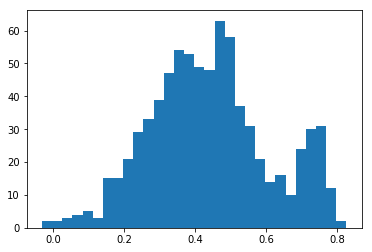

Top 101 corr


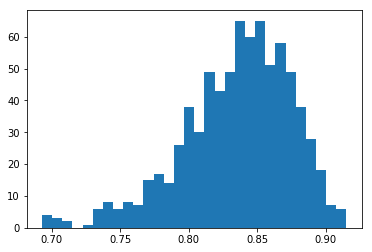

Round 1
Top 501 corr


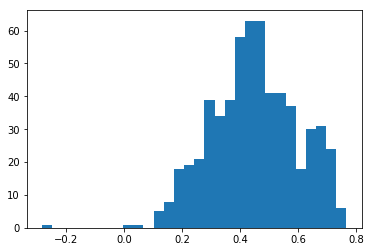

Top 101 corr


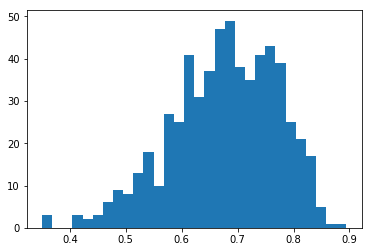

In [109]:
#Let's investigate the correlation

from scipy.stats import spearmanr

for round_num in range(2):
    print("Round",round_num)
    coarse_affmat = coarse_affmats[round_num]
    nn_affmat = nn_affmats[round_num]

    correlations = []
    correlations_top = []
    for i,nn_affmat_row in enumerate(nn_affmat):
        corr = spearmanr(a = nn_affmat_row[np.abs(nn_affmat_row) > 0],
                         b = coarse_affmat[i][np.abs(nn_affmat_row) > 0]).correlation
        sorted_coarse_indices = [x[0] for x in sorted(enumerate(coarse_affmat[i]), reverse=True)]
        sorted_nn_indices = [x[0] for x in sorted(enumerate(nn_affmat_row), reverse=True)]
        top_100_corr = spearmanr(a = nn_affmat_row[sorted_nn_indices[:101]],
                                 b = coarse_affmat[i][sorted_nn_indices[:101]]).correlation
        correlations.append(corr)
        correlations_top.append(top_100_corr)
    
    from matplotlib import pyplot as plt
    print("Top 501 corr")
    plt.hist(correlations, bins=30)
    plt.show()
    print("Top 101 corr")
    plt.hist(correlations_top, bins=30)
    plt.show()